<a href="https://colab.research.google.com/github/Kishore-C-Dev/ML-AI/blob/main/ML/transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-12-16 23:47:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-12-16 23:47:31 (13.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import walk_through_dir, unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-12-16 19:12:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  86.4MB/s    in 20s     

2024-12-16 19:12:31 (79.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

#walk_through_dir("101_food_classes_10_percent/")


In [ ]:
import tensorflow as tf
train_101_food_classes=tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode="categorical",image_size=(224,224))
test_101_food_classes=tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode="categorical",image_size=(224,224),shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
check_point_path="101_food_classes_10_percent_model_checkpoint.weights.h5"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(check_point_path,save_weights_only=True,monitor="val_accuracy",save_best_only=True)

In [ ]:
from os import name
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)],
    #tf.keras.layers.Rescaling(1/255),
    name="data_augmentation"

)

In [ ]:
#transferLearning Feature extraction model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=tf.keras.layers.Dense(101,activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
feature_extraction_history=model.fit(train_101_food_classes,epochs=5,validation_data=test_101_food_classes,validation_steps=int(0.15*len(test_101_food_classes)))

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.0397 - loss: 4.5072 - val_accuracy: 0.1721 - val_loss: 3.8515
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.2554 - loss: 3.6346 - val_accuracy: 0.3257 - val_loss: 2.9482
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.3652 - loss: 2.9951 - val_accuracy: 0.5132 - val_loss: 2.1116
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.4195 - loss: 2.6273 - val_accuracy: 0.4907 - val_loss: 2.1481
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - accuracy: 0.4737 - loss: 2.3950 - val_accuracy: 0.5519 - val_loss: 1.8410


In [ ]:
feature_extraction_finetuning_results=model.evaluate(test_101_food_classes)

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.4835 - loss: 2.0954


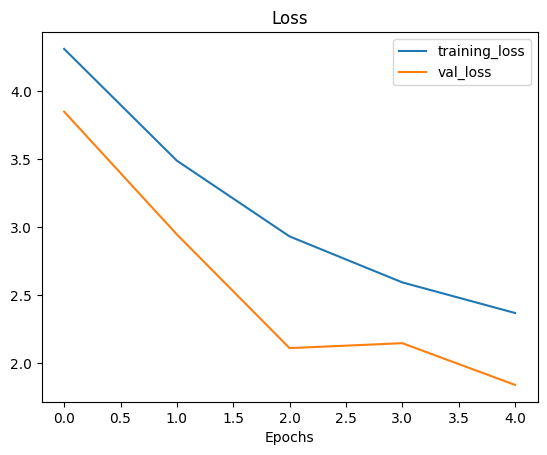

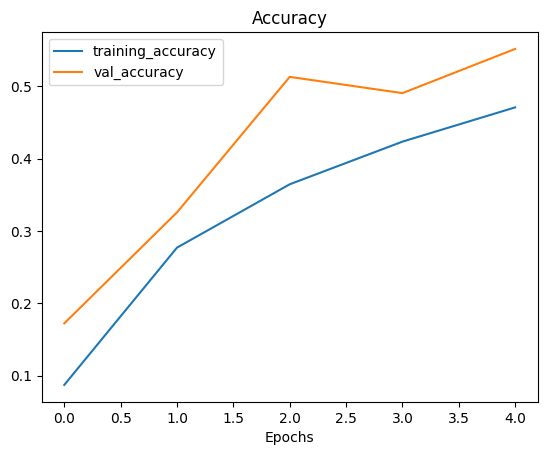

In [ ]:
plot_loss_curves(feature_extraction_history)

In [ ]:
#unfreeze all the layers in base model
base_model.trainable=True
#Refreeze all layers except last 5
for layers in base_model.layers[:-5] :
  layers.trainable=False
#base_model.summary()

In [ ]:
#recompile the model after changing base_model with lower training rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=["accuracy"])

In [ ]:
for layers in model.layers :
  print(layers.name,layers.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
for layer_number ,layer in enumerate(model.layers[2].layers) :
  print(layer_number,layer,layer.trainable)

0 <InputLayer name=input_layer_1, built=True> False
1 <Rescaling name=rescaling_2, built=True> False
2 <Normalization name=normalization_1, built=True> False
3 <Rescaling name=rescaling_3, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <C

In [ ]:
#finetune the model after unfreezeing last 5 layers with another 5 layers total will be 10 epochs
feature_extarction_finetuning_history=model.fit(train_101_food_classes,epochs=10,validation_data=test_101_food_classes,
                                                validation_steps=int(0.15*len(test_101_food_classes)),
                                                initial_epoch=feature_extraction_history.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 190ms/step - accuracy: 0.5039 - loss: 2.2167 - val_accuracy: 0.4590 - val_loss: 2.1673
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 176ms/step - accuracy: 0.5171 - loss: 2.0578 - val_accuracy: 0.5320 - val_loss: 1.8353
Epoch 7/10


KeyboardInterrupt: 

In [ ]:
feature_extraction_finetuning_results_unfreeze=model.evaluate(test_101_food_classes)

In [ ]:
print(feature_extraction_finetuning_results_unfreeze)
print(feature_extraction_finetuning_results)

In [ ]:
plot_loss_curves(feature_extarction_finetuning_history)

In [ ]:
model.save("/content/drive/MyDrive/MyFolder/101_food_classes_10_percent_saved_model.keras")

In [ ]:
import tensorflow as tf
loaded_model=tf.keras.models.load_model("/content/drive/MyDrive/MyFolder/101_food_classes_10_percent_saved_model.keras")

In [ ]:
loaded_model_results=loaded_model.evaluate(test_101_food_classes)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - accuracy: 0.5320 - loss: 1.8008


[1.6631395816802979, 0.5629702806472778]

In [ ]:
predict_classes=loaded_model.predict(test_101_food_classes)

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 72ms/step


In [ ]:
len(predict_classes)

25250

In [ ]:
predict_classes[0].argmax()

52

In [ ]:
predict_labels=tf.argmax(predict_classes,axis=1)


In [ ]:
predict_labels[:10].numpy()

array([52,  0,  0, 80, 79, 78, 29, 62,  9,  0])

In [ ]:
#convert test data  format to compare with predict classes
y_labels = []
for images, labels in test_101_food_classes.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#lets try accuracy score function from scikitlearn
from sklearn.metrics import accuracy_score
sk_learn_accuracy=accuracy_score(y_labels,predict_labels)
sk_learn_accuracy

0.5629702970297029

In [ ]:
import numpy as np
np.isclose(loaded_model_results[1],sk_learn_accuracy)

True

In [ ]:
#list of classname
class_names=(test_101_food_classes.class_names)
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_labels,predict_labels,class_names,figsize=(100,100),text_size=20)

In [ ]:
#presicion , recall and F1 - classification report

from sklearn.metrics import classification_report
print(classification_report(y_labels,predict_labels))

              precision    recall  f1-score   support

           0       0.32      0.14      0.20       250
           1       0.38      0.76      0.51       250
           2       0.81      0.37      0.51       250
           3       0.83      0.46      0.59       250
           4       0.46      0.50      0.48       250
           5       0.43      0.30      0.36       250
           6       0.82      0.63      0.71       250
           7       0.70      0.78      0.74       250
           8       0.30      0.44      0.35       250
           9       0.33      0.70      0.45       250
          10       0.38      0.51      0.43       250
          11       0.84      0.45      0.58       250
          12       0.73      0.51      0.60       250
          13       0.40      0.64      0.49       250
          14       0.50      0.55      0.52       250
          15       0.50      0.24      0.33       250
          16       0.75      0.42      0.54       250
          17       0.36    

In [ ]:
classification_report_dict=classification_report(y_labels,predict_labels,output_dict=True)
classification_report_dict

{'0': {'precision': 0.3157894736842105,
  'recall': 0.144,
  'f1-score': 0.1978021978021978,
  'support': 250.0},
 '1': {'precision': 0.38028169014084506,
  'recall': 0.756,
  'f1-score': 0.5060240963855421,
  'support': 250.0},
 '2': {'precision': 0.8141592920353983,
  'recall': 0.368,
  'f1-score': 0.5068870523415978,
  'support': 250.0},
 '3': {'precision': 0.8333333333333334,
  'recall': 0.46,
  'f1-score': 0.5927835051546392,
  'support': 250.0},
 '4': {'precision': 0.46494464944649444,
  'recall': 0.504,
  'f1-score': 0.4836852207293666,
  'support': 250.0},
 '5': {'precision': 0.4293785310734463,
  'recall': 0.304,
  'f1-score': 0.3559718969555035,
  'support': 250.0},
 '6': {'precision': 0.8177083333333334,
  'recall': 0.628,
  'f1-score': 0.7104072398190046,
  'support': 250.0},
 '7': {'precision': 0.697508896797153,
  'recall': 0.784,
  'f1-score': 0.7382297551789078,
  'support': 250.0},
 '8': {'precision': 0.2978142076502732,
  'recall': 0.436,
  'f1-score': 0.3538961038961

In [ ]:
#lets plot a graph fo F1 scores for each class
class_f1_scores ={}

for key,value in classification_report_dict.items() :
  if key == 'accuracy' :
    break
  else :
    class_f1_scores[class_names[int(key)]]=value["f1-score"]
class_f1_scores




{'apple_pie': 0.1978021978021978,
 'baby_back_ribs': 0.5060240963855421,
 'baklava': 0.5068870523415978,
 'beef_carpaccio': 0.5927835051546392,
 'beef_tartare': 0.4836852207293666,
 'beet_salad': 0.3559718969555035,
 'beignets': 0.7104072398190046,
 'bibimbap': 0.7382297551789078,
 'bread_pudding': 0.3538961038961039,
 'breakfast_burrito': 0.4461538461538462,
 'bruschetta': 0.4341880341880342,
 'caesar_salad': 0.5848563968668408,
 'cannoli': 0.6009389671361502,
 'caprese_salad': 0.4945904173106646,
 'carrot_cake': 0.5247148288973384,
 'ceviche': 0.32707774798927614,
 'cheese_plate': 0.5360824742268041,
 'cheesecake': 0.3757115749525617,
 'chicken_curry': 0.47334754797441364,
 'chicken_quesadilla': 0.6,
 'chicken_wings': 0.5867768595041323,
 'chocolate_cake': 0.5423728813559322,
 'chocolate_mousse': 0.3081570996978852,
 'churros': 0.7122153209109731,
 'clam_chowder': 0.7078384798099763,
 'club_sandwich': 0.6138996138996139,
 'crab_cakes': 0.3801980198019802,
 'creme_brulee': 0.719056974

In [ ]:
import pandas as pd
f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),"f1_scores":list(class_f1_scores.values())}).sort_values("f1_scores",ascending=False)
f1_scores

,class_names,f1_scores
33,edamame,0.926829
75,pho,0.847966
32,dumplings,0.843621
91,spaghetti_carbonara,0.836773
54,hot_and_sour_soup,0.831325
...,...,...
22,chocolate_mousse,0.308157
39,foie_gras,0.295455
93,steak,0.268793
0,apple_pie,0.197802


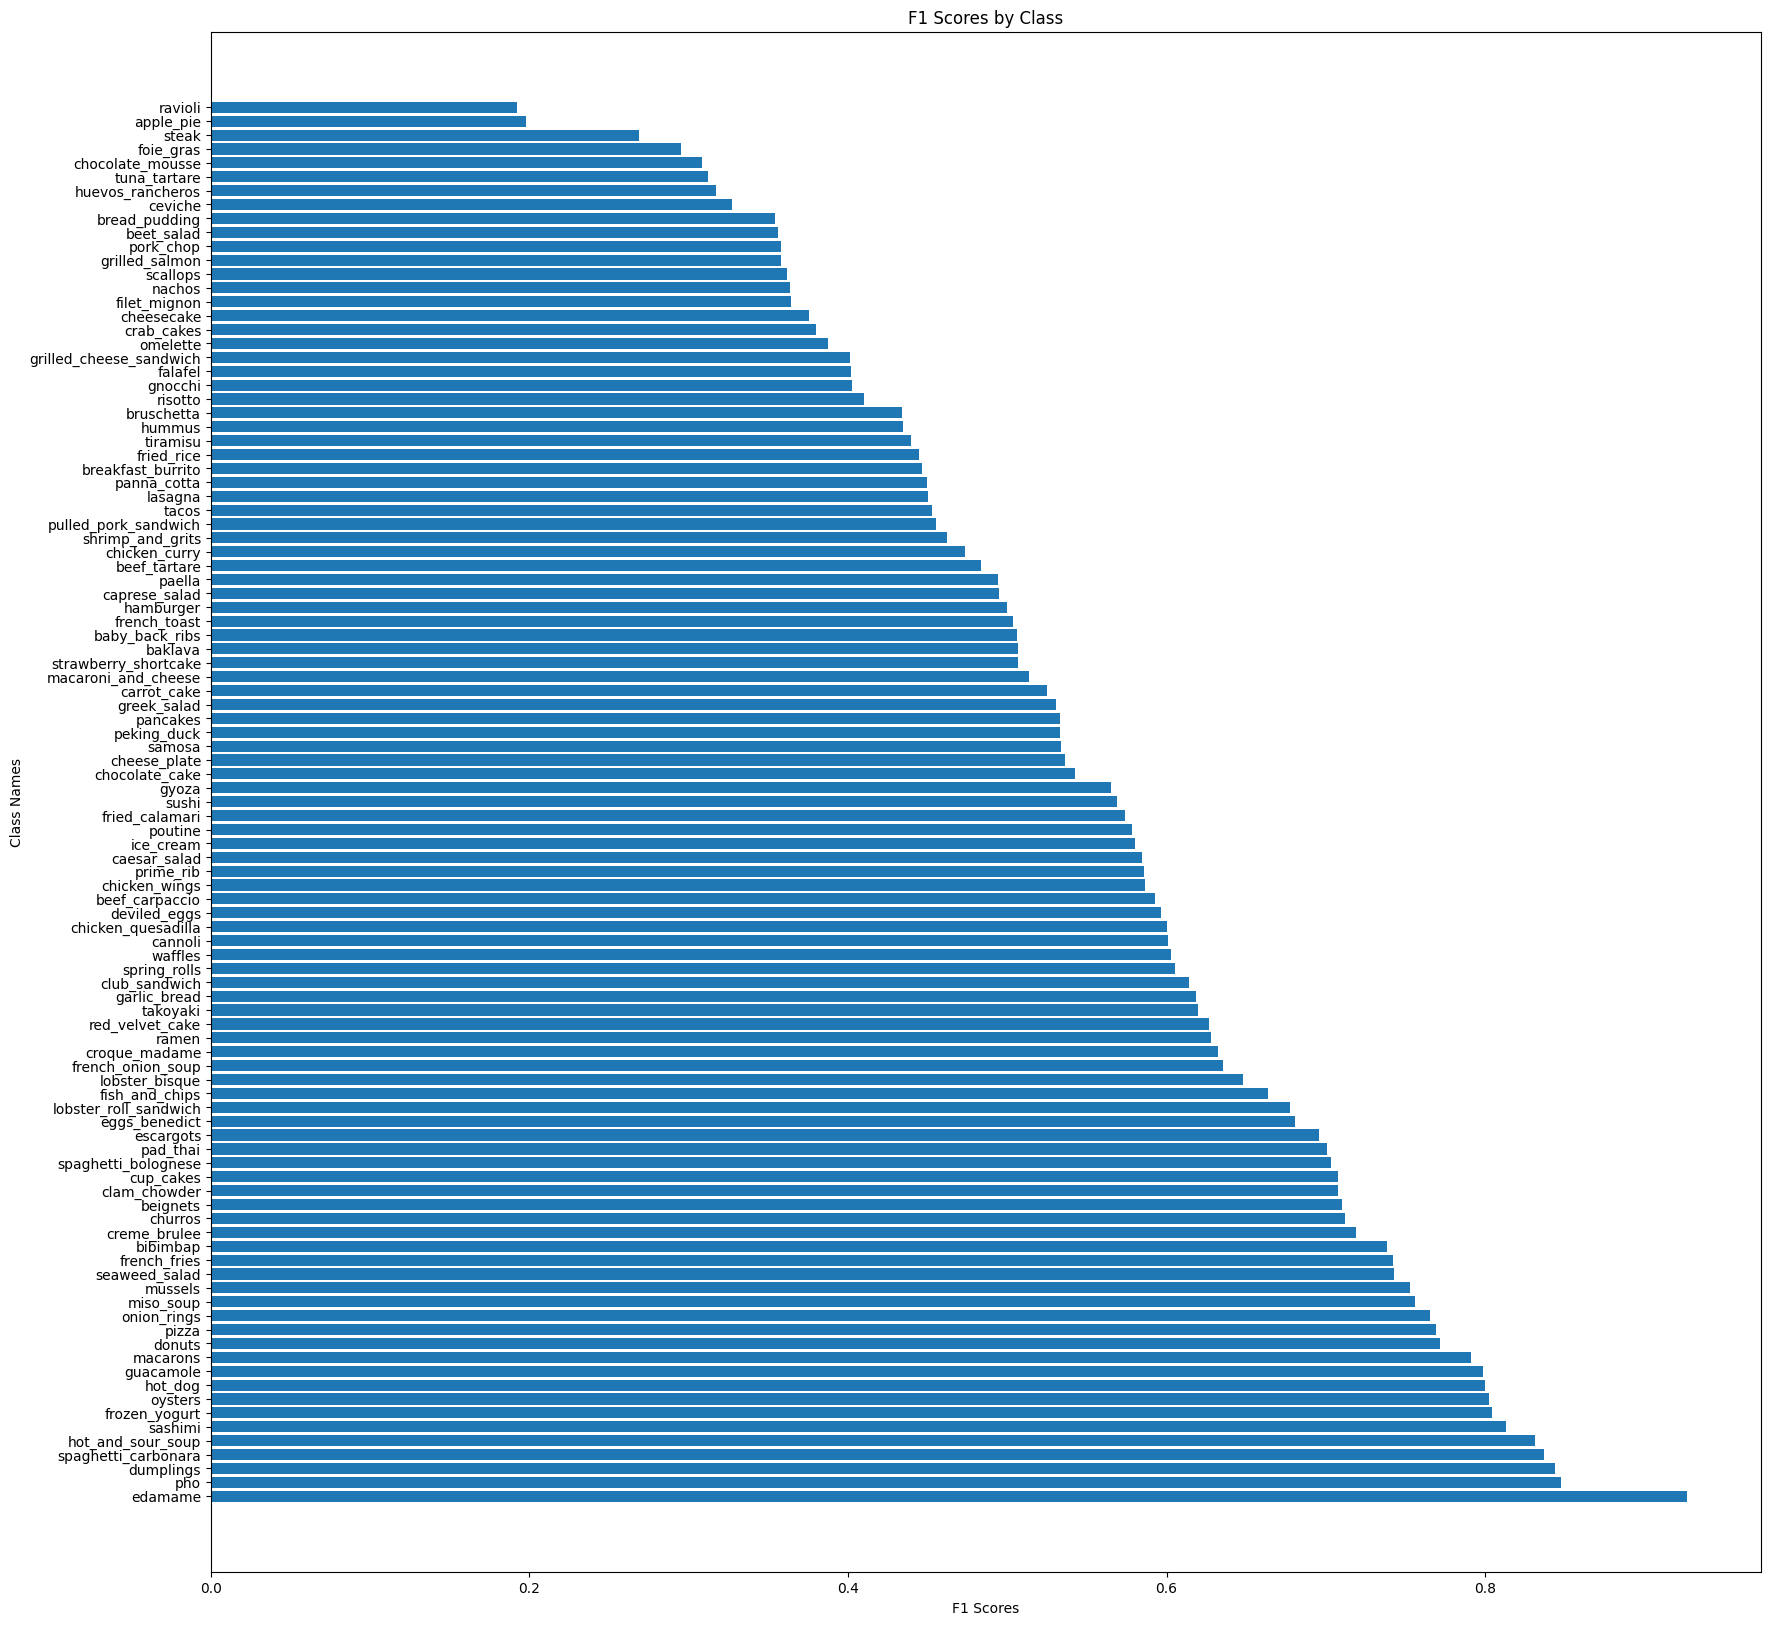

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(y=f1_scores["class_names"], width=f1_scores["f1_scores"])  # Use `barh` for horizontal bars
ax.set_xlabel("F1 Scores")
ax.set_ylabel("Class Names")
ax.set_title("F1 Scores by Class")
plt.show()

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img,channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


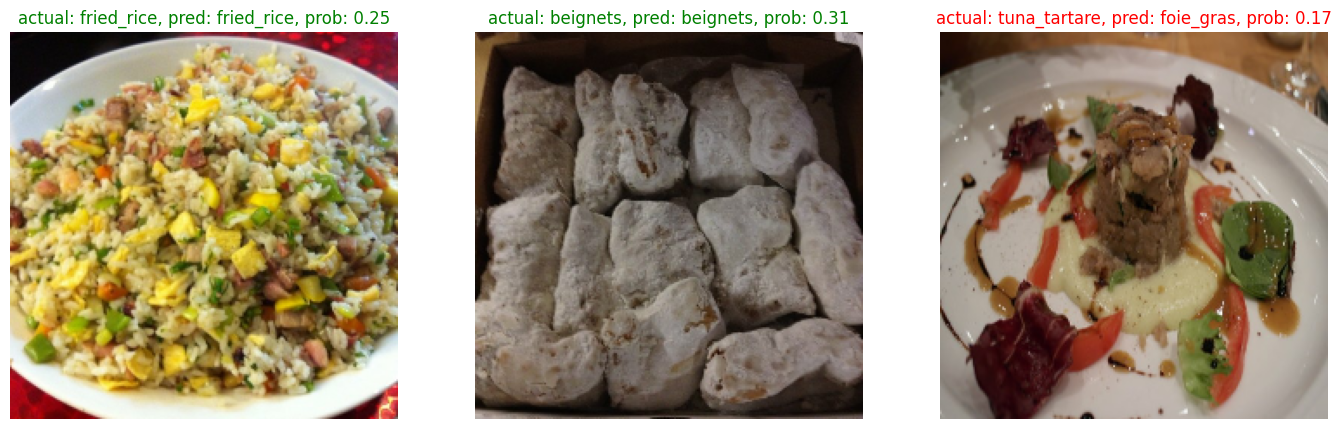

In [ ]:
import os
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()]
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)